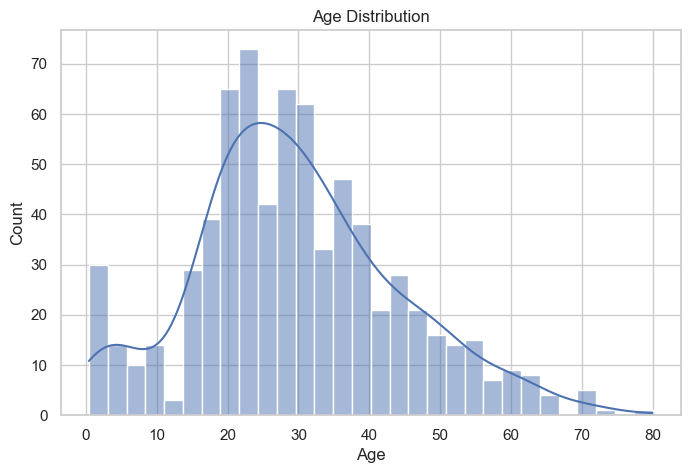

Saved: outputs/plots\hist_age.png


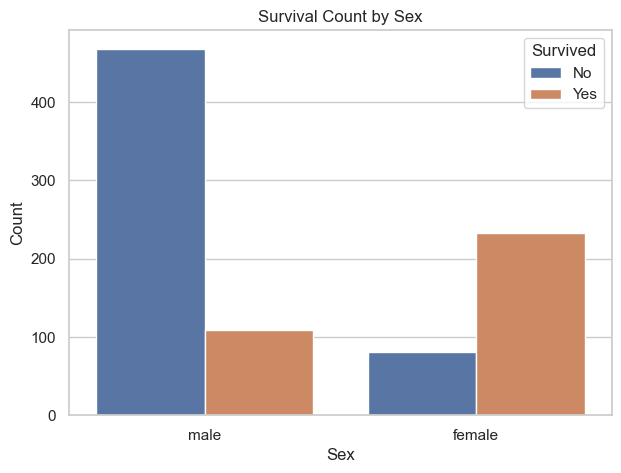

Saved: outputs/plots\count_survived_sex.png


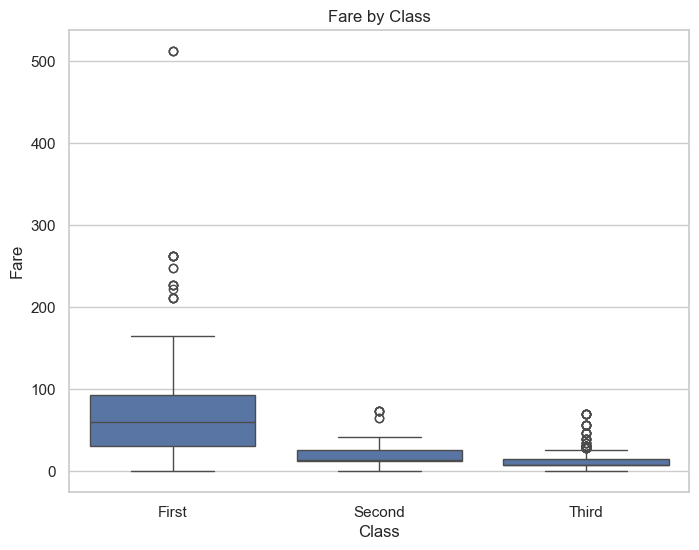

Saved: outputs/plots\box_fare_by_class.png


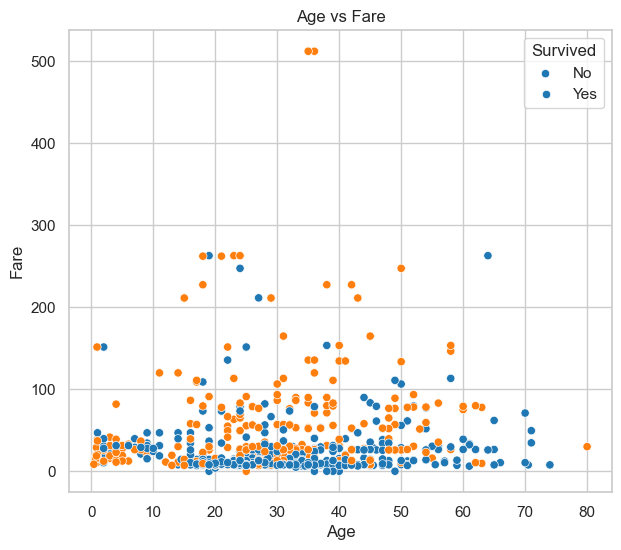

Saved: outputs/plots\scatter_age_fare.png


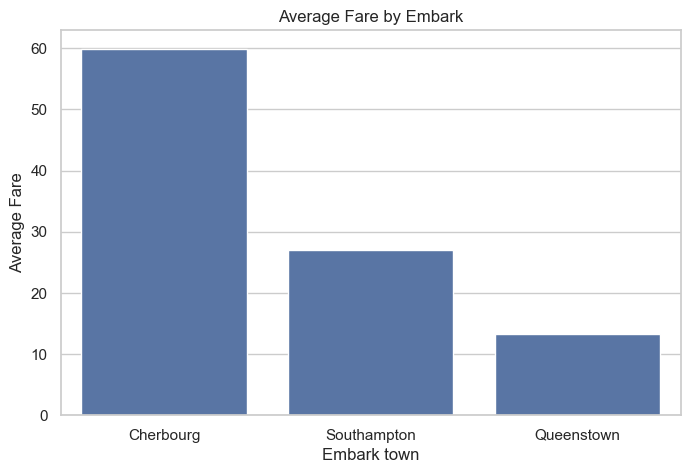

Saved: outputs/plots\bar_avg_fare_by_embark.png


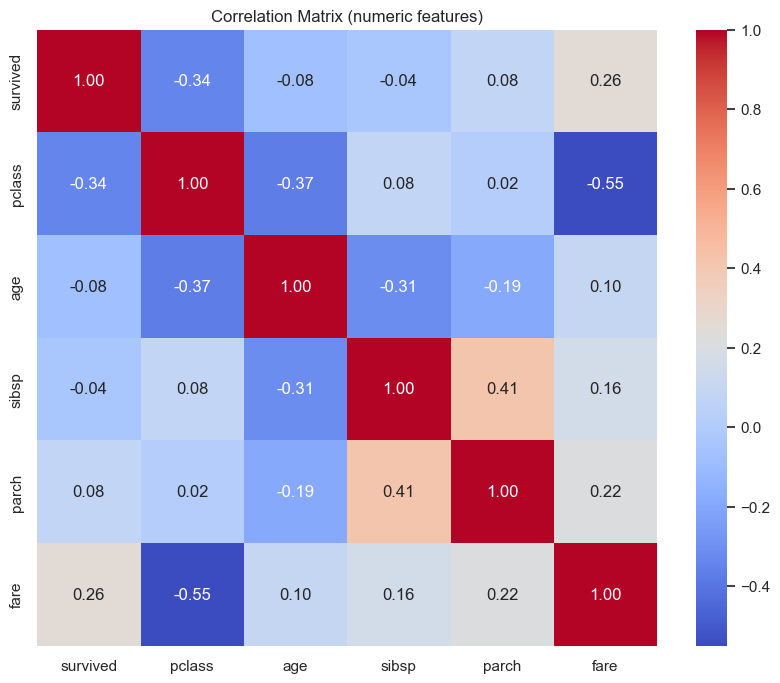

Saved: outputs/plots\heatmap_correlation.png


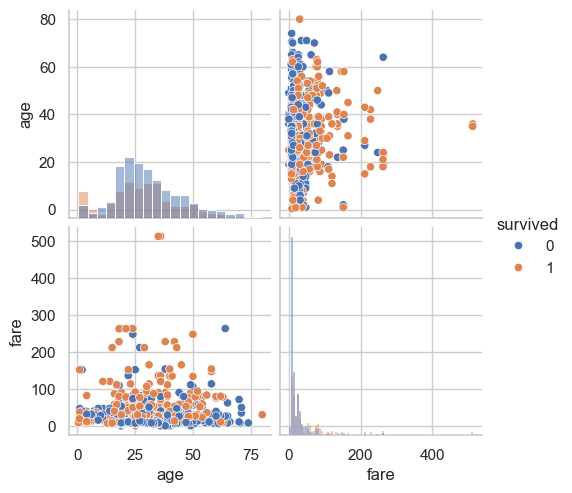

Saved: outputs/plots\pairplot_age_fare_survived.png


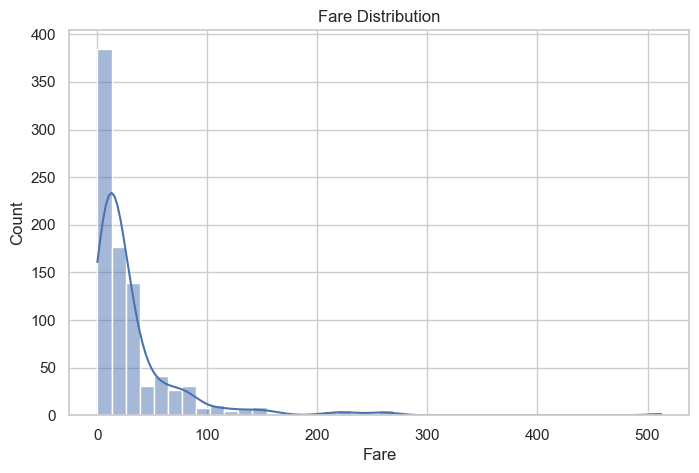

Saved: outputs/plots\dist_fare.png

All plots attempted. Check the outputs folder for saved PNGs.


In [3]:
"""
save_plots.py
Generates 8 visualizations for the Titanic dataset and saves them to outputs/plots/.

Usage:
    python save_plots.py            # uses seaborn's titanic dataset if local CSV not present
    python save_plots.py --data path/to/titanic.csv --out outputs/plots
"""

import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def load_titanic(path=None):
    if path:
        df = pd.read_csv(path)
        return df
    try:
        return sns.load_dataset("titanic")
    except Exception as e:
        raise RuntimeError("Could not load titanic dataset via seaborn and no local path provided.") from e


def save_fig(fig, out_path, dpi=300):
    ensure_dir(os.path.dirname(out_path))
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show(fig)


def plot_hist_age(df, out_path):
    if "age" not in df.columns:
        print("Skipping histogram of age — 'age' column not present.")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(df["age"].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title("Age Distribution")
    ax.set_xlabel("Age")
    ax.set_ylabel("Count")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_count_survived_sex(df, out_path):
    if not set(["sex", "survived"]).issubset(df.columns):
        print("Skipping countplot survived vs sex — required columns missing.")
        return
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.countplot(data=df, x="sex", hue="survived", ax=ax)
    ax.set_title("Survival Count by Sex")
    ax.set_xlabel("Sex")
    ax.set_ylabel("Count")
    ax.legend(title="Survived", labels=["No", "Yes"])
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_box_fare_by_class(df, out_path):
    # prefer 'class' (string), fallback to 'pclass'
    if "fare" not in df.columns:
        print("Skipping boxplot fare by class — 'fare' column missing.")
        return
    class_col = "class" if "class" in df.columns else ("pclass" if "pclass" in df.columns else None)
    if class_col is None:
        print("Skipping boxplot fare by class — no class/pclass column.")
        return
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=df, x=class_col, y="fare", ax=ax)
    ax.set_title("Fare by Class")
    ax.set_xlabel(class_col.capitalize())
    ax.set_ylabel("Fare")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_scatter_age_fare(df, out_path):
    if not set(["age", "fare"]).issubset(df.columns):
        print("Skipping scatter age vs fare — required columns missing.")
        return
    fig, ax = plt.subplots(figsize=(7, 6))
    # color by survived if available
    if "survived" in df.columns:
        sns.scatterplot(data=df, x="age", y="fare", hue="survived", palette="tab10", ax=ax)
        ax.legend(title="Survived", labels=["No", "Yes"])
    else:
        sns.scatterplot(data=df, x="age", y="fare", ax=ax)
    ax.set_title("Age vs Fare")
    ax.set_xlabel("Age")
    ax.set_ylabel("Fare")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_bar_avg_fare_by_embark(df, out_path):
    # prefer 'embark_town' then 'embarked'
    if "fare" not in df.columns:
        print("Skipping barplot average fare by embark — 'fare' missing.")
        return
    embark_col = None
    if "embark_town" in df.columns:
        embark_col = "embark_town"
    elif "embarked" in df.columns:
        embark_col = "embarked"
    if embark_col is None:
        print("Skipping barplot average fare by embark — no embark column.")
        return
    # compute average
    agg = df.groupby(embark_col)["fare"].mean().reset_index().sort_values("fare", ascending=False)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=agg, x=embark_col, y="fare", ax=ax)
    ax.set_title("Average Fare by Embark")
    ax.set_xlabel(embark_col.replace("_", " ").capitalize())
    ax.set_ylabel("Average Fare")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_heatmap_corr(df, out_path):
    # use only numeric cols
    num_df = df.select_dtypes(include=[np.number])
    if num_df.shape[1] < 2:
        print("Skipping heatmap — not enough numeric columns.")
        return
    corr = num_df.corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
    ax.set_title("Correlation Matrix (numeric features)")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def plot_pairplot(df, out_path):
    cols = [c for c in ["age", "fare", "survived"] if c in df.columns]
    if len(cols) < 2:
        print("Skipping pairplot — not enough of the [age, fare, survived] columns present.")
        return
    # drop rows with NA in selected cols for clear pairplot
    pair_df = df[cols].dropna()
    g = sns.pairplot(pair_df, hue="survived" if "survived" in cols else None, diag_kind="hist")
    # pairplot returns a FacetGrid; save with plt.savefig
    ensure_dir(os.path.dirname(out_path))
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)


def plot_dist_fare(df, out_path):
    if "fare" not in df.columns:
        print("Skipping fare distribution — 'fare' missing.")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(df["fare"].dropna(), bins=40, kde=True, ax=ax)
    ax.set_title("Fare Distribution")
    ax.set_xlabel("Fare")
    ax.set_ylabel("Count")
    save_fig(fig, out_path)
    print("Saved:", out_path)


def main(data_path=None, out_dir="outputs/plots"):
    ensure_dir(out_dir)
    df = load_titanic(data_path)

    # quick normalization if seaborn dataset uses different naming
    # (we keep original columns but sometimes 'class' exists as category; that's fine)
    # produce plots
    plot_hist_age(df, os.path.join(out_dir, "hist_age.png"))
    plot_count_survived_sex(df, os.path.join(out_dir, "count_survived_sex.png"))
    plot_box_fare_by_class(df, os.path.join(out_dir, "box_fare_by_class.png"))
    plot_scatter_age_fare(df, os.path.join(out_dir, "scatter_age_fare.png"))
    plot_bar_avg_fare_by_embark(df, os.path.join(out_dir, "bar_avg_fare_by_embark.png"))
    plot_heatmap_corr(df, os.path.join(out_dir, "heatmap_correlation.png"))
    plot_pairplot(df, os.path.join(out_dir, "pairplot_age_fare_survived.png"))
    plot_dist_fare(df, os.path.join(out_dir, "dist_fare.png"))

    print("\nAll plots attempted. Check the outputs folder for saved PNGs.")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Generate Titanic visualizations")
    parser.add_argument("--data", "-d", help="Path to local titanic csv (optional)", default=None)
    parser.add_argument("--out", "-o", help="Output folder for plots", default="outputs/plots")
    args, unknown = parser.parse_known_args()

    main(args.data, args.out)
